<a href="https://colab.research.google.com/github/zkatemor/thesaurus/blob/word2vec_keras_sample/dictionary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [517]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [518]:
pip install pymorphy2

In [0]:
import pickle

In [0]:
import numpy as np
import pandas as pd
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import collections
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Activation, Dropout
from keras.layers.embeddings import Embedding
import gensim.downloader
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
import pymorphy2

# DataSet
 
Загрузка словаря RuSentilex в формате .csv
*   https://www.labinform.ru/pub/rusentilex/index.htm



In [0]:
df = pd.read_csv('drive/My Drive/coursework/rusentilex.csv')

In [522]:
df.head(3)

,term,tone
0,остепеняться,positive
1,трудолюбивый,positive
2,беспалевный,positive


In [523]:
len(df)

10668

Всего в словаре 10668 слов.

In [0]:
# получение id тональности
def get_ids(all_tones):
    result = []

    for tone in all_tones:
        result.append(all_tones.unique().tolist().index(tone))

    return result

In [0]:
labels = get_ids(df['tone'])
total_words = df['term']
# перемешиваем
total_words, labels = sklearn.utils.shuffle(total_words, labels)

In [0]:
# добавление части речи к слову для корректной работы с русскоязычной word2vec
def add_part_of_speech(word):
    p = pymorphy2.MorphAnalyzer().parse(word)[0]
    word += '_' + str(p.tag.POS)
    return word

In [0]:
# получаем список для корректной работы с моделью
#sentences = [[add_part_of_speech(word)] for word in total_words]

with open('drive/My Drive/coursework/rusentilex_sentences.pickle', 'rb') as handle:
        sentences = pickle.load(handle)
# получаем id тональностей для сохраненного списка токенов (sentences)
with open('drive/My Drive/coursework/rusentilex_labels.pickle', 'rb') as handle:
        labels = pickle.load(handle)

In [560]:
sentences[:5]

[['толстопузость_NOUN'],
 ['винтик_NOUN'],
 ['оскорбить_INFN'],
 ['рациональный_ADJF'],
 ['равнодушный_ADJF']]

In [0]:
counter = collections.Counter()

In [0]:
#считаем максимальную длину предложений (в словаре могут быть словосочетания), а также частоту всех слов, считанных из файла
maxlen = 0
for words in sentences:
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1

In [532]:
vocab_sz = len(counter) + 1 
print('Размер словаря: ' + str(vocab_sz))

Размер словаря: 10669


Задаем необходимые константные значения и загружаем русскоязычную модель Word2Vec

In [0]:
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
EPOCH_SIZE = 10
BATCH_SIZE = 32
NUM_FILTERS = 256
NUM_WORDS = 3

In [534]:
word2vec_model = gensim.downloader.load("word2vec-ruscorpora-300")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Работа с Keras

In [0]:
#создаём матрицу размером размерность словаря*размерность вектора слова
embedding_weights = np.zeros((vocab_sz, EMBEDDING_DIM))
index = 0
#сортируем слова по частоте встречаемости
sorted_counter = counter.most_common()
#для каждого слова из нашего словаря задаём вектор из word2vec_model в матрицу
for word in sorted_counter:
    try:
      embedding_weights[index, :] = word2vec_model[word[0]] 
      index+=1     
    #если нет слова в словаре word2vec_model
    except KeyError:
      index+=1
      pass

Собираем модель для обучения:
1 слой модели – русскоязычный word2vec

In [0]:
import keras

In [0]:
model = Sequential()
model.add(Embedding(vocab_sz, EMBEDDING_DIM, input_length=maxlen, weights=[embedding_weights],
                    trainable=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv1D(50,
                                1,
                                padding='valid',
                                activation='relu',
                                strides=1))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(250))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [727]:
model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 1, 300)            3200700   
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 300)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 50)             15050     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 250)               12750     
_________________________________________________________________
dropout_29 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_28 (Activation)   (None, 250)             

# Train Model

Обучение модели

In [0]:
# Создание единого словаря (слово -> число) для преобразования на основе списка текстов sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

In [0]:
#заменяем слова каждого предложения на числа
X = tokenizer.texts_to_sequences(sentences)
#уравниваем все предложения до размера maxlen
X = pad_sequences(X, maxlen = maxlen)

In [0]:
y = to_categorical(labels)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [756]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCH_SIZE, 
                    callbacks=[keras.callbacks.ModelCheckpoint('drive/My Drive/coursework/model.h5', save_best_only=True)],
                    validation_split=VALIDATION_SPLIT, verbose=1)

Train on 6827 samples, validate on 1707 samples
Epoch 1/10
6827/6827 [==============================] - 1s 205us/step - loss: 0.0346 - acc: 0.9870 - val_loss: 0.0382 - val_acc: 0.9836
Epoch 2/10
6827/6827 [==============================] - 1s 195us/step - loss: 0.0031 - acc: 0.9988 - val_loss: 0.0372 - val_acc: 0.9836
Epoch 3/10
6827/6827 [==============================] - 1s 200us/step - loss: 6.4594e-05 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 0.9836
Epoch 4/10
6827/6827 [==============================] - 1s 191us/step - loss: 4.2676e-06 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9836
Epoch 5/10
6827/6827 [==============================] - 1s 195us/step - loss: 4.3596e-06 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9836
Epoch 6/10
6827/6827 [==============================] - 1s 194us/step - loss: 3.7960e-06 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9836
Epoch 7/10
6827/6827 [==============================] - 1s 199us/step - loss: 1.2533e-06 - acc: 1.0000 - val_loss: 0.037

In [760]:
score = model.evaluate(X_test, Y_test)
print("Test accuracy: {:.3f}".format(score[1]))

2134/2134 [==============================] - 0s 77us/step
Test accuracy: 0.988


Построение графика потерь:

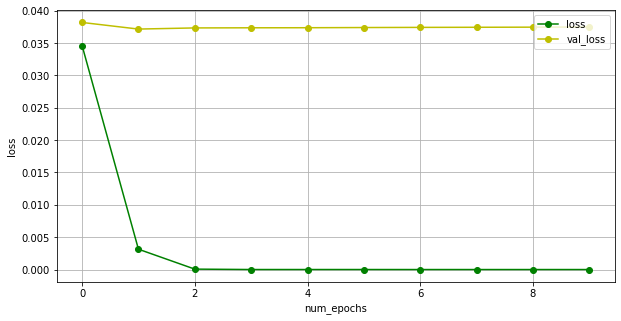

In [757]:
x = range(EPOCH_SIZE)
plt.figure(figsize = (10, 5))
plt.grid(True)
plt.plot(x, history.history['loss'], 'go-', label = 'loss')
plt.plot(x, history.history['val_loss'], 'yo-', label = 'val_loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(loc='upper right')

Отчёт по предсказанию (по разным метрикам) + матрица ошибок:

In [0]:
prediction = model.predict_classes(X_test)

In [0]:
prediction_tones = from_tone(prediction, df['tone'].unique().tolist()) 

In [0]:
y_test = Y_test.tolist()
y_test_tones = []

for i in range(len(y_test)):
  y_test_tones.append(df['tone'].unique()[y_test[i].index(1)])

In [0]:
from sklearn.metrics import classification_report

In [766]:
print(classification_report(y_test_tones, prediction_tones))

              precision    recall  f1-score   support

    negative       0.98      1.00      0.99      1417
     neutral       1.00      0.98      0.99       141
    positive       1.00      0.97      0.98       576

    accuracy                           0.99      2134
   macro avg       0.99      0.98      0.99      2134
weighted avg       0.99      0.99      0.99      2134



In [0]:
import seaborn as sn

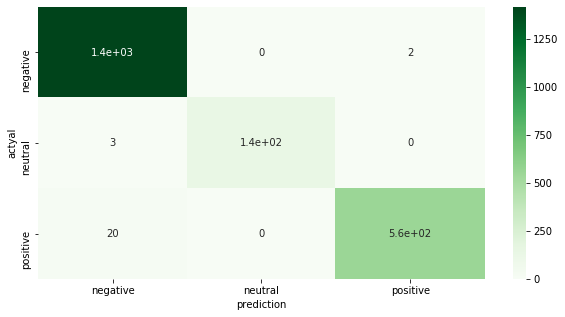

In [776]:
data = {'prediction': prediction_tones,
        'actual':    y_test_tones }

df = pd.DataFrame(data, columns = ['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames = ['actyal'], colnames = ['prediction'])
plt.figure(figsize=(10, 5))
sn.heatmap(confusion_matrix, annot=True,cmap="Greens")

Сохранение токенизированных слов и id тональностей (их построение занимает много времени, поэтому так будет проще менять структуру модели и др. в будущем)

In [0]:
#with open('drive/My Drive/coursework/rusentilex_sentences.pickle', 'wb') as f:
       # pickle.dump(sentences, f)

#with open('drive/My Drive/coursework/rusentilex_labels.pickle', 'wb') as f:
       # pickle.dump(labels, f)

# Test Model

Проверка работоспособности на небольших данных

In [0]:
# метод для преобразования из id тональности в его словесное значение (0 -> positive)
def from_tone(prediction, tones):
  answers = []

  for i in range(prediction.shape[0]):
    answers.append(tones[prediction[i]])

  return answers

In [0]:
test_samples = ['ненужный', 'отвратительный', 'прикольный', 'милый', 'жестокий', 'шедевр', 'никакой']

In [701]:
test_samples = [[add_part_of_speech(test)] for test in test_samples]
test_samples

[['ненужный_ADJF'],
 ['отвратительный_ADJF'],
 ['прикольный_ADJF'],
 ['милый_ADJF'],
 ['жестокий_ADJF'],
 ['шедевр_NOUN'],
 ['никакой_ADJF']]

In [0]:
test_samples_tokens = tokenizer.texts_to_sequences(test_samples)

In [0]:
test_samples_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

In [0]:
predict = model.predict_classes(x=test_samples_pad)

In [705]:
answers = from_tone(predict, df['tone'].unique().tolist()) 
answers

['negative',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative']

# Классификация неразмеченного словаря, полученного из отзывов

In [0]:
import json

In [0]:
# загружаем неразмеченный словарь из json файла
with open('drive/My Drive/coursework/unallocated_dictionary.json', 'r', encoding='utf-8') as f:
    js = json.load(f)

In [707]:
js[:5]

[['телефон_NOUN', 13004],
 ['очень_ADVB', 7831],
 ['экран_NOUN', 6981],
 ['хороший_ADJF', 5305],
 ['камера_NOUN', 5178]]

In [0]:
unallocated_words = [[word[0]] for word in js]

In [709]:
unallocated_words[:6]

[['телефон_NOUN'],
 ['очень_ADVB'],
 ['экран_NOUN'],
 ['хороший_ADJF'],
 ['камера_NOUN'],
 ['весь_ADJF']]

In [0]:
unallocated_words_tokens = tokenizer.texts_to_sequences(unallocated_words)

In [0]:
unallocated_words__pad = pad_sequences(unallocated_words_tokens, maxlen=maxlen)

In [0]:
predict = model.predict_classes(x=unallocated_words__pad)

In [0]:
answers = from_tone(predict, df['tone'].unique().tolist())

In [0]:
keys = [word[0] for word in js]

In [0]:
dictionary = dict(zip(keys, answers))

In [0]:
import itertools

In [717]:
dict(itertools.islice(dictionary.items(), 15))

{'батарея_NOUN': 'negative',
 'весь_ADJF': 'negative',
 'год_NOUN': 'negative',
 'день_NOUN': 'negative',
 'камера_NOUN': 'negative',
 'качество_NOUN': 'negative',
 'один_ADJF': 'negative',
 'отличный_ADJF': 'positive',
 'очень_ADVB': 'negative',
 'приложение_NOUN': 'negative',
 'работать_INFN': 'negative',
 'телефон_NOUN': 'negative',
 'хороший_ADJF': 'positive',
 'цена_NOUN': 'negative',
 'экран_NOUN': 'negative'}

In [0]:
# сохраняем размеченный словарь в json файл
with open('drive/My Drive/coursework/tagged_dictionary.json', 'w', encoding='utf-8') as f:
    json.dump(dictionary, f, ensure_ascii=False, indent=4)

In [0]:
# так же сохраняем словарь в csv файл
import csv
from itertools import zip_longest
d = [keys, answers]
export_data = zip_longest(*d, fillvalue = '')
with open('drive/My Drive/coursework/tagged_dictionary.csv', 'w', encoding='utf-8', newline='') as f:
      wr = csv.writer(f)
      wr.writerow(("term", "tone"))
      wr.writerows(export_data)
f.close()

In [0]:
tagged_dictionary = pd.read_csv('drive/My Drive/coursework/tagged_dictionary.csv')

In [723]:
tagged_dictionary[:15]

,term,tone
0,телефон_NOUN,negative
1,очень_ADVB,negative
2,экран_NOUN,negative
3,хороший_ADJF,positive
4,камера_NOUN,negative
5,весь_ADJF,negative
6,работать_INFN,negative
7,день_NOUN,negative
8,батарея_NOUN,negative
9,приложение_NOUN,negative
